In [151]:
import pandas as pd
import numpy as np
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# set some themes
sns.set_theme(style="whitegrid")
sns.set(rc={'text.usetex' : False})
# sns.set_context("paper")

pd.options.mode.chained_assignment = None  # default='warn'  suppress pesky warning


root_dir = '/home/thien/research/pseudogroups/CivilComments/splitpgl_sweep_logs/p1.0_rwgroup_dro_wd0.01_lr1e-05/'
meta_data_path = '/home/thien/research/datasets/jigsaw/data/all_data_with_identities.csv'
# val_or_test = 'test'
# epoch = 3
# seed = 0


def get_output_and_meta_df(epoch, seed, val_or_test, part="part2_oll-1rw_rgl_group_dro_valp0.5_wd0_lr1e-05"):
    file_path = root_dir + f'{part}_s{seed}/output_{val_or_test}_epoch_{epoch}.csv'
    output_df = pd.read_csv(file_path)
    
    metadata_df = pd.read_csv(meta_data_path)
    test_df = metadata_df.iloc[output_df[f'indices_None_epoch_{epoch}_val']]
    test_df['labels'] = (test_df['toxicity'] >= 0.5).astype(int)  # this gives a warning... 
    test_df.reset_index(inplace=True)
    
    return output_df, test_df


def analyze_accs(output_df, test_df, epoch, verbose=False):
    all_groups = [
            'male',
            'female',
            'christian',
            'muslim',
            'other_religion',
            'black',
            'white',
            'LGBTQ'
    ]

    pred_col_name = f'y_pred_None_epoch_{epoch}_val'
    true_col_name = f'y_true_None_epoch_{epoch}_val'

    group_acc_dict = {}
    group_n_dict = {}

    for toxic in range(2):  # in 0 or 1
        for g in range(len(all_groups)):
            group_idx = toxic*len(all_groups) + g
            idxs = (test_df['labels'] == toxic) & (test_df[all_groups[g]] == 1)
            total_n_g = sum(idxs)
            group_n_dict[(all_groups[g],toxic)] = total_n_g
            if total_n_g <= 0:
                group_acc_dict[(all_groups[g],toxic)] = 1  # vacuously perfect
                continue
            correct_pred = sum(test_df[idxs]['labels'] == output_df[idxs][pred_col_name])
            group_acc_dict[(all_groups[g],toxic)] =  correct_pred/total_n_g
    wg_acc = min(v for k, v in group_acc_dict.items())
    avg_acc = sum(output_df[pred_col_name] == output_df[true_col_name])/len(output_df)
    if verbose:
        print(f"\tWG Acc = {wg_acc} \n\tAvg Acc = {avg_acc}")
        pprint(group_acc_dict)
    return avg_acc, wg_acc


def plot_fn(df, x_str, y_strs, my_labels, x_label=None, title=None):
    save_path = f"{x_str}-{'_'.join(y_strs)}.eps".replace(" ", "-")
    print("saving plot at: ", save_path)
    plot_df = pd.DataFrame()
    plot_df[x_str] = df[x_str]
    for y in y_strs:
        plot_df[y] = df[y]

    melt_df = pd.melt(plot_df, [x_str])

    # set size and plot
    plt.figure(figsize=(8,5))

    ax = sns.lineplot(data=melt_df, x=x_str, y='value', hue='variable')
    handles, labels  =  ax.get_legend_handles_labels()
    ax.legend(handles, my_labels, title='')
    if x_label is None:
        x_label = x_str
    plt.xlabel(x_label)
    plt.ylabel('Accuracies (\%)')

    plt.title(title)
    # plt.tick_params(left=False,
    #             bottom=False,
    #             labelleft=False,
    #             labelbottom=False)

    # save
    plt.savefig(save_path, format='eps', bbox_inches='tight')
    plt.show()

In [158]:
!ls /home/thien/research/pseudogroups/CivilComments/splitpgl_sweep_logs/p1.0_rwgroup_dro_wd0.01_lr1e-05/part1_s0

0_model.pth		  output_val_epoch_0.csv  tmp
log.txt			  part1and2_data_p1.0	  train.csv
output_test_epoch_0.csv   part1and2_data_valp0	  val.csv
output_train_epoch_0.csv  test.csv


[0] {'epoch': 0, 'val_avg': 0.8728862328463922, 'val_wg': 0.6414048059149723, 'test_avg': 0.8699152352334395, 'test_wg': 0.6514864010120177}
[1] {'epoch': 1, 'val_avg': 0.8749225320938468, 'val_wg': 0.6632653061224489, 'test_avg': 0.8726435544393117, 'test_wg': 0.7129770992366412}
[2] {'epoch': 2, 'val_avg': 0.903452855245684, 'val_wg': 0.5867346938775511, 'test_avg': 0.9025952669267914, 'test_wg': 0.6580152671755726}
[3] {'epoch': 3, 'val_avg': 0.9047587428065516, 'val_wg': 0.6173469387755102, 'test_avg': 0.9025578926910944, 'test_wg': 0.6900763358778625}
[4] {'epoch': 4, 'val_avg': 0.9105577689243027, 'val_wg': 0.5714285714285714, 'test_avg': 0.9084630219312015, 'test_wg': 0.6566037735849056}
[5] {'epoch': 5, 'val_avg': 0.915692784417884, 'val_wg': 0.5204081632653061, 'test_avg': 0.9133739965017715, 'test_wg': 0.634046052631579}
saving plot at:  epoch-val_wg_test_wg.eps


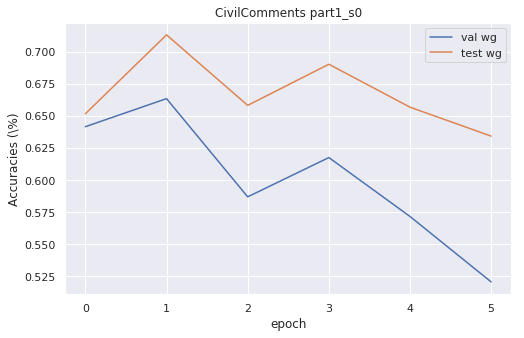

saving plot at:  epoch-val_avg_test_avg.eps


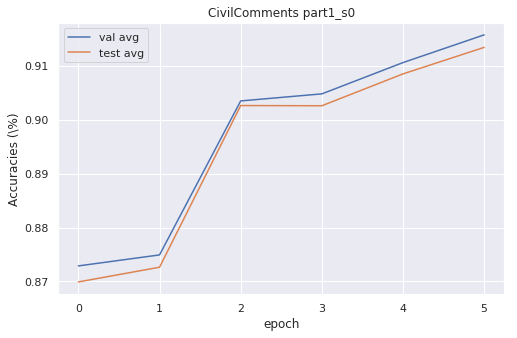

In [159]:
# part = 'part2_oll-1rw_rgl_group_dro_p1.0_wd0_lr1e-05'
part = 'part1'
seed = 0
n_epochs = 6

stats = {}
result_df = pd.DataFrame()

for epoch in range(n_epochs):
    stats['epoch'] = epoch
    
    output_df, test_df = get_output_and_meta_df(epoch, seed, 'val', part)
    val_avg_acc, val_wg_acc = analyze_accs(output_df, test_df, epoch)
    stats['val_avg'] = val_avg_acc
    stats['val_wg'] = val_wg_acc
    
    output_df, test_df = get_output_and_meta_df(epoch, seed, 'test', part)
    test_avg_acc, test_wg_acc = analyze_accs(output_df, test_df, epoch)
    stats['test_avg'] = test_avg_acc
    stats['test_wg'] = test_wg_acc
    
    print(f'[{epoch}] {stats}')
    result_df = result_df.append(stats, ignore_index=True)

title = f'CivilComments {part}_s{seed}'
plot_fn(result_df, x_str='epoch', y_strs=['val_wg', 'test_wg'], my_labels = ['val wg', 'test wg'], title=title)
plot_fn(result_df, x_str='epoch', y_strs=['val_avg', 'test_avg'], my_labels = ['val avg', 'test avg'], title=title)
